In [126]:
import os, sys, re, datetime, copy
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))

In [127]:
# User-defined global parameters

list_of_X_CICO = np.arange(0.05, 6.00+0.05, 0.05) #<TODO># tune this range
list_of_N_CO = 10**np.arange(17.0, 20.0+0.125, 0.25)
#list_of_T_kin = [25., 25., 25., 50., 50., 100.]
#list_of_d_V_for_T_kin = [3., 15., 30., 60., 60., 60.]
#list_of_T_kin = [15., 25., 30., 50., 50., 300.]
#list_of_d_V_for_T_kin = [4., 10., 30., 50., 50., 90.]
#list_of_CO_abundance_for_T_kin = np.array([3e-4, 3e-4, 3e-4, 3e-4, 3e-4, 3e-4])
list_of_T_kin = [15., 20., 25., 30., 50., 100.]
list_of_d_V_for_T_kin = [4., 10., 20., 60., 50., 90.]
list_of_CO_abundance_for_T_kin = np.array([1e-4, 2e-4, 3e-4, 3e-4, 3e-4, 3e-4])
list_of_highlight_text_label_for_T_kin = ['Galactic clouds', # Solomon+87,Heyer13
                                          'NGC3627 disk GMCs', 
                                          'NGC3627 bar-ends',
                                          'NGC3627 center',
                                          'NGC1808 starburst ring',
                                          'NGC7469 AGN nucleus']
list_of_highlight_Flux_Kkms_CO10_range_for_T_kin = [
    (30.,50.), (100.,200.), (350.,500.), (1000.,1400.), (800.,1000.), (2000.,2200.) ] # K km s-1

#list_of_highlight_alphaCO_for_T_kin = [4.35/1.36]*len(list_of_highlight_text_label_for_T_kin)
#list_of_highlight_alphaCO_for_T_kin = [np.max([0.3*(t/100.)**(-1.1), 0.6]) for t in list_of_T_kin]
#func_alphaCO = lambda t: np.max([0.3*(t/100.)**(-1.1), 0.5])
#list_of_highlight_alphaCO_for_T_kin = [func_alphaCO(t) for t in list_of_T_kin]
#func_alphaCO = lambda t, abu: \
#                   np.max([0.3*(t/100.)**(-1.1) * (3e-4) / abu, 
#                           0.5]) # see 'calc_LTE_alpha_CO_CI.ipynb'
func_alphaCO = lambda t, abu: \
                    0.15 * (1 + (t/75.)**2.4) * (t/75.)**(-1.2) * \
                    (3e-4) / abu # 20220112, see 'calc_LTE_alpha_CO_CI.ipynb'

list_of_highlight_alphaCO_for_T_kin = np.array([func_alphaCO(t, abu) for t, abu in \
                                                list(zip(list_of_T_kin, list_of_CO_abundance_for_T_kin))])

list_of_highlight_Sigma_H2_range_for_T_kin = [None]*len(list_of_highlight_text_label_for_T_kin)
list_of_highlight_R_CI10CO21_for_T_kin = [0.1, 0.1, 0.1, 0.08, 0.2, 0.5]
list_of_highlight_line_color_for_T_kin = ['magenta', 'blue', 'green', 'lime', 'orange', 'red']

CO_abundance2 = 3e-4 # for another class of Galactic cloud
T_kin2 = 7.5 # for another class of Galactic cloud

out_fig_size = [13., 5.8]

out_fig_margin = dict(left=0.08, right=0.94, bottom=0.10, top=0.83)

out_fig_name = 'Plot_RADEX_R_CI10CO21_sim_XCICO'


#in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_dv_%gkms'%(line_width)
in_table_name_by_d_V = {}
for d_V in list_of_d_V_for_T_kin:
    d_V_str = '%g'%(d_V)
    if d_V_str not in in_table_name_by_d_V:
        in_table_name = 'out_table_RADEX_R_CI10CO21_sim_XCICO_dv_%gkms'%(d_V)
        in_table_name_by_d_V[d_V_str] = in_table_name
#


In [128]:
# Read table

data_table_by_d_V = {}
for d_V in list_of_d_V_for_T_kin:
    d_V_str = '%g'%(d_V)
    if d_V_str not in data_table_by_d_V:
        print('Reading "%s"'%(in_table_name_by_d_V[d_V_str] + '.csv'))
        data_table = Table.read(in_table_name_by_d_V[d_V_str] + '.csv', format='csv')
        data_table_by_d_V[d_V_str] = copy.copy(data_table)
        # check T_kin in table
        for T_kin in list_of_T_kin:
            uniq_T_kin = np.unique(data_table['T_kin'].data)
            if not np.any(np.isclose(T_kin, uniq_T_kin)):
                raise Exception('Error! T_kin {} not in table {}!'.format(T_kin, str(uniq_T_kin)))


Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_4kms.csv"
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_10kms.csv"
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_20kms.csv"
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_60kms.csv"
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_50kms.csv"
Reading "out_table_RADEX_R_CI10CO21_sim_XCICO_dv_90kms.csv"


In [129]:
# Define function to read x y from table

def read_X_CICO_R_CICO_from_table(
        N_CO, 
        d_V, 
        T_kin, 
        n_H2 = None, 
        LTE = False, 
    ):
    
    global data_table_by_d_V
    
    d_V_str = '%g'%(d_V)
    
    in_table = data_table_by_d_V[d_V_str]
    
    #print('T_kin:', np.unique(in_table['T_kin'].data))
    
    if LTE:
        colsuffix = '_LTE'
    else:
        colsuffix = '_NonLTE'
    
    select_by_N_CO_T_kin = np.logical_and.reduce((
            np.isclose(np.log10(in_table['N_CO']), np.log10(N_CO)), 
            np.isclose(np.log10(in_table['n_H2']), np.log10(n_H2)), 
            np.isclose(in_table['T_kin'], T_kin), 
        ))
    x = in_table['X_CICO'][select_by_N_CO_T_kin]
    y = in_table['R_CI10CO21'+colsuffix][select_by_N_CO_T_kin]
    mask_CO_opt_thin = in_table['tau_0_CO21'+colsuffix][select_by_N_CO_T_kin]<1.
    mask_CI_opt_thin = in_table['tau_0_CI10'+colsuffix][select_by_N_CO_T_kin]<1.
    
    return x, y, mask_CO_opt_thin, mask_CI_opt_thin


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.04306841264003835, 0.6188836664483366)
highlight_X_CICO_range (0.07, 0.129)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.11723318384627406, 0.6197638991565215)
panel 2
CO_

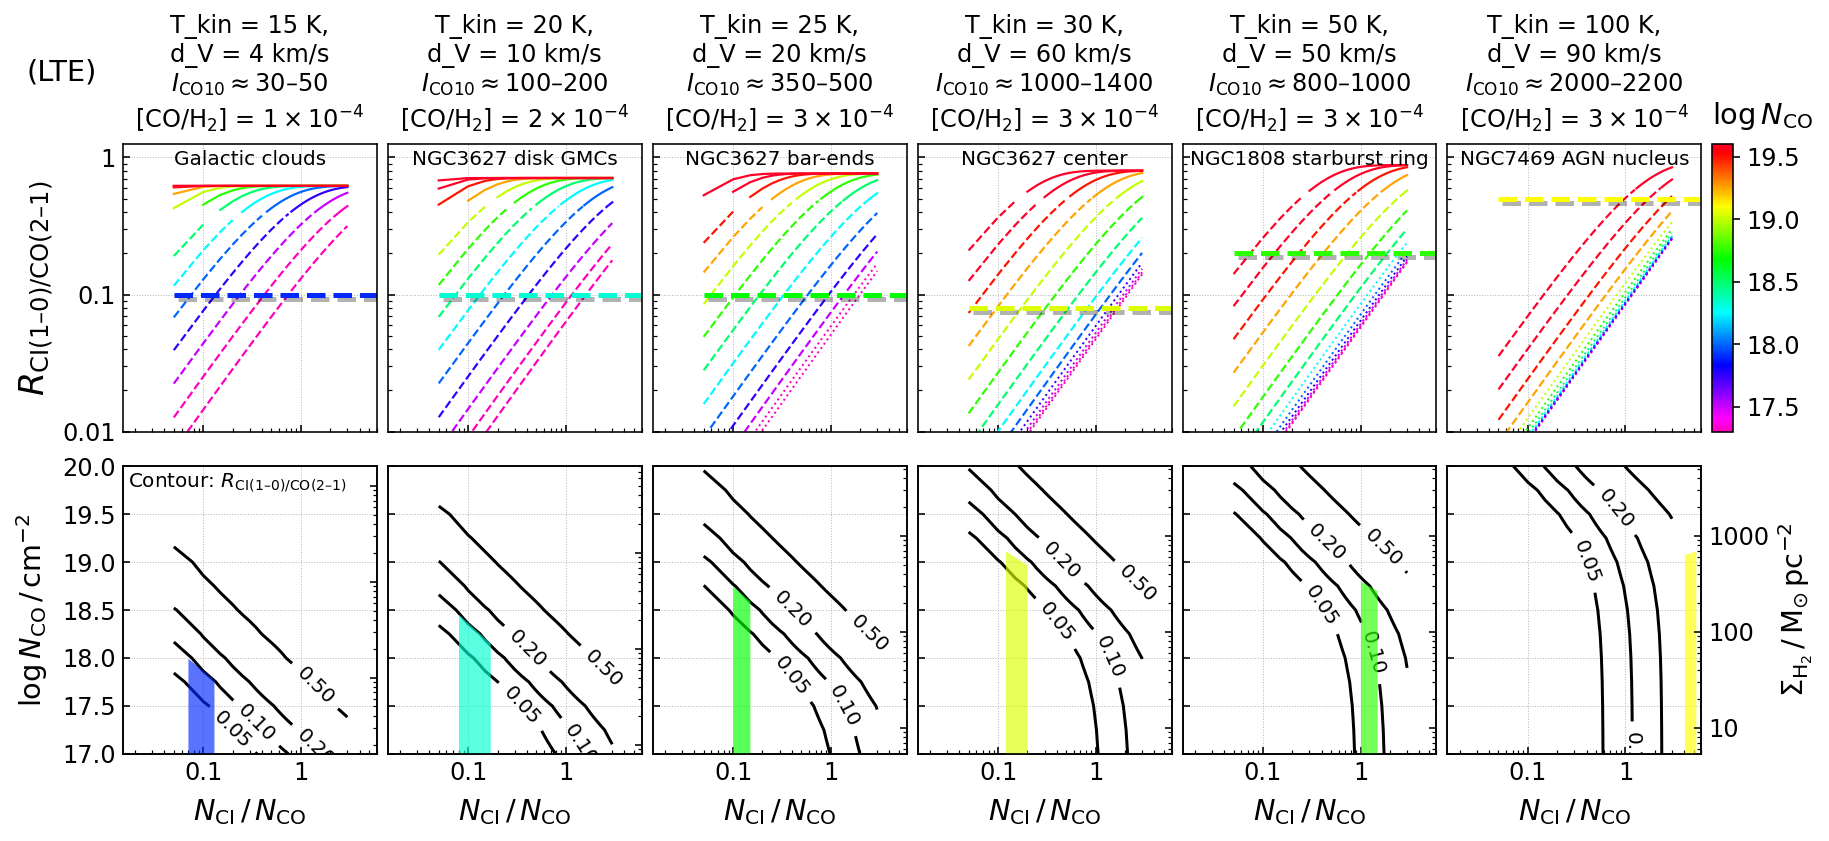

In [130]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects


def make_a_figure(
        out_figure_file, 
        n_H2 = None, 
        LTE = True, 
    ):
    # 
    global list_of_X_CICO
    global list_of_N_CO
    global list_of_T_kin
    global list_of_d_V_for_T_kin
    # 
    minima = np.nan
    maxima = np.nan
    fig = plt.figure(figsize=out_fig_size)
    gs = gridspec.GridSpec(ncols=len(list_of_T_kin)+1, nrows=2, 
                           figure=fig, width_ratios=[1]*len(list_of_T_kin)+[0.08], 
                           wspace=0.05, hspace=0.12)
    upper_axes = []
    for i in range(len(list_of_T_kin)):
        ax = fig.add_subplot(gs[0, i])
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([0.01, 1.25])
        ax.set_xlim([0.015, 6.00])
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        upper_axes.append(ax)
    lower_axes = []
    for i in range(len(list_of_T_kin)):
        lower_axes.append(fig.add_subplot(gs[1, i]))
    fig.subplots_adjust(**out_fig_margin)
    lower_right_axes = []

    #norm = matplotlib.colors.LogNorm(vmin=np.min(list_of_N_CO), 
    #                                 vmax=np.max(list_of_N_CO), clip=True)
    #norm = matplotlib.colors.Normalize(vmin=np.min(np.log10(list_of_N_CO)), 
    #                                   vmax=np.max(np.log10(list_of_N_CO)), clip=True)
    #norm = matplotlib.colors.Normalize(vmin=18.0, vmax=19.5, clip=True)
    norm = matplotlib.colors.Normalize(vmin=np.min(np.log10(list_of_N_CO))+0.3, 
                                       vmax=np.max(np.log10(list_of_N_CO))-0.4, clip=True)
    cmap = cm.gist_rainbow_r # cm.RdYlBu_r # cm.gist_rainbow_r # cm.RdYlBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
    colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    # out_figure_file = 'Plot_LTE_RCI10CO21_vs_XCICO_varying_N_CO_T_kin.pdf'


    for idx_T_kin, T_kin in enumerate(list_of_T_kin):

        x_array_for_contour = []
        y_array_for_contour = []
        data_array_for_contour = []

        icol = idx_T_kin

        d_V = list_of_d_V_for_T_kin[idx_T_kin]
        d_V_str = '{:.0f}'.format(d_V)
        T_kin_str = '{:.0f}'.format(T_kin)
        I_CO_str = '{:g}–{:g}'.format(*list_of_highlight_Flux_Kkms_CO10_range_for_T_kin[idx_T_kin])
        CO_abundance = list_of_CO_abundance_for_T_kin[idx_T_kin]
        CO_abundance_str = r'${:.0f} \times 10^{{-4}}$'.format(
                               list_of_CO_abundance_for_T_kin[idx_T_kin]/1e-4
                           )
        panel_title_str = f'T_kin = {T_kin_str} K,' + '\n' + \
                          f'd_V = {d_V_str} km/s' + '\n' + \
                          r'$I_{\mathrm{CO10}} \approx $' + f'{I_CO_str}' + '\n' + \
                          f'$\mathrm{{[CO/H_2]}}$ = {CO_abundance_str}'
                          # panel title
        ax = upper_axes[icol]
        ax.set_title(panel_title_str, fontsize='large', pad=8)
        if icol == 0:
            ax.set_ylabel(r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', fontsize='xx-large', labelpad=3)
        if icol != 0:
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
        ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the upper panels
        ax.tick_params(which='both', direction='in', labelsize='large')

        # top left text label
        highlight_text_label = list_of_highlight_text_label_for_T_kin[idx_T_kin]
        ax.text(0.5, 0.98, highlight_text_label, ha='center', va='top', transform=ax.transAxes)

        for i_N_CO, N_CO in enumerate(list_of_N_CO):
            
            # read X_CICO, R_CICO, and optical depth masks for each (T_kin, N_CO) grid
            x, y, mask_CO_opt_thin, mask_CI_opt_thin = read_X_CICO_R_CICO_from_table(
                N_CO=N_CO, d_V=d_V, T_kin=T_kin, n_H2=n_H2, LTE=LTE)

            # plot R_CI10CO21 versus X_CICO curves in the upper panel
            mask = np.logical_and(mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.0, ls='dotted', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='dashed', alpha=1.0)

            mask = np.logical_and(~mask_CO_opt_thin, ~mask_CI_opt_thin)
            if np.count_nonzero(mask) > 0:
                ax.plot(x[mask], y[mask], color=colormapper.to_rgba(np.log10(N_CO)), 
                        lw=1.1, ls='solid', alpha=1.0)

            # compute global extrema
            miny = np.min(y)
            maxy = np.max(y)
            if np.isnan(minima) or minima > miny:
                minima = miny
            if np.isnan(maxima) or maxima < maxy:
                maxima = maxy

            # prepare data array for contour
            if len(x_array_for_contour) == 0:
                x_array_for_contour = x # X_CICO
            y_array_for_contour.append(np.log10(N_CO))
            data_array_for_contour.append(y) # R_CI10CO21

        # plot contour in the lower panel
        x = np.array(x_array_for_contour)
        y = np.array(y_array_for_contour)
        data_array_for_contour = np.array(data_array_for_contour)
        ax = lower_axes[icol]
        ax.tick_params(which='both', direction='in', labelsize='large')
        cs = ax.contour(x, y, data_array_for_contour, 
                        levels=[0.05, 0.1, 0.2, 0.5], colors='k') # show R_CICO = 0.05, 0.1 and 0.2 contours
        ax.set_xlabel(r'$N_{\mathrm{CI}} \, / \, N_{\mathrm{CO}}$', fontsize='x-large', labelpad=6)
        ax.set_xscale('log')
        ax.set_xlim([0.015, 6.00])
        ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        axRight = ax.twinx()
        axRight.set_yscale('log')
        axRight.set_ylim(10**np.array(ax.get_ylim()) / CO_abundance * 1.60141791e-20) 
        # (const.m_p+const.m_p-const.m_e) * ((1.*u.pc).to(u.cm).value)**2 / const.M_sun = 1.60141791e-20, 
        # [CO/H2] = 3e-4
        axRight.tick_params(which='both', direction='in', labelsize='large')
        if icol == 0:
            ax.set_ylabel(r'$\log N_{\mathrm{CO}} \, / \, \mathrm{cm^{-2}}$', 
                          fontsize='x-large', labelpad=6) # show y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.NullFormatter()) # hide right y major tick labels
            axRight.yaxis.set_minor_formatter(ticker.NullFormatter()) # hide right y minor tick labels
        elif icol == len(list_of_T_kin)-1:
            axRight.set_ylabel(r'$\Sigma_{\mathrm{H_2}} \, / \, \mathrm{M_{\odot} \, pc^{-2}}$', 
                               fontsize='x-large', labelpad=4) # show right y axis title in the last column panel
            axRight.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g')) # show right y axis tick labels
            axRight.tick_params(axis='y', labelsize='large')
            ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks at left
        else:
            ax.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide y ticks in the non-last-column panel
            axRight.yaxis.set_major_formatter(
                ticker.NullFormatter()) # hide right y major tick labels in the non-last-column panel
            axRight.yaxis.set_minor_formatter(
                ticker.NullFormatter()) # hide right y minor tick labels in the non-last-column panel
        ax.clabel(cs, cs.levels, inline=True)
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        lower_right_axes.append(axRight)

        # plot highlight shading in the lower panels
        highlight_text_label = list_of_highlight_text_label_for_T_kin[idx_T_kin]
        highlight_line_color = list_of_highlight_line_color_for_T_kin[idx_T_kin]
        highlight_Flux_Kkms_CO10_range = list_of_highlight_Flux_Kkms_CO10_range_for_T_kin[idx_T_kin]
        highlight_Sigma_H2_range = list_of_highlight_Sigma_H2_range_for_T_kin[idx_T_kin]
        highlight_R_CI10CO21 = list_of_highlight_R_CI10CO21_for_T_kin[idx_T_kin]
        highlight_alphaCO = list_of_highlight_alphaCO_for_T_kin[idx_T_kin]
        if highlight_text_label is not None and highlight_text_label != '':
            from scipy.interpolate import interp2d
            func_interp = interp2d(x, y, data_array_for_contour)
            x_interp = np.linspace(np.min(x), np.max(x), num=300, endpoint=True)
            y_interp = np.linspace(np.min(y), np.max(y), num=300, endpoint=True)
            data_array_interp = func_interp(x_interp, y_interp)
            x_grid, y_grid = np.meshgrid(x_interp, y_interp)
            # 
            #highlight_val = highlight_R_CI10CO21
            if highlight_Sigma_H2_range is None:
                highlight_Sigma_H2_range = (\
                    highlight_Flux_Kkms_CO10_range[0] * highlight_alphaCO, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                    highlight_Flux_Kkms_CO10_range[1] * highlight_alphaCO, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                )
            highlight_N_CO_range = np.array(highlight_Sigma_H2_range) * CO_abundance / 1.60141791e-20 # cm^-2
            highlight_N_CO_mean = np.mean(highlight_N_CO_range)
            highlight_line_color = colormapper.to_rgba(np.log10(highlight_N_CO_mean))
            print('panel', idx_T_kin+1)
            print('CO_abundance', CO_abundance)
            print('highlight_R_CI10CO21', highlight_R_CI10CO21)
            print('highlight_Flux_Kkms_CO10_range', highlight_Flux_Kkms_CO10_range)
            print('highlight_alphaCO', highlight_alphaCO)
            print('highlight_Sigma_H2_range', highlight_Sigma_H2_range, 
                  'vs. right axis y range', axRight.get_ylim())
            print('highlight_N_CO_range', highlight_N_CO_range)
            print('highlight_N_CO_range in log10', np.log10(highlight_N_CO_range))
            print('highlight_N_CO_mean', highlight_N_CO_mean, 
                  'vs. left axis y range', 10**np.array(ax.get_ylim()))
            print('highlight_line_color', highlight_line_color)
            highlight_ymin, highlight_ymax = highlight_Sigma_H2_range
            highlight_ymask = np.logical_and(
                                10**y_grid > highlight_ymin * CO_abundance / 1.60141791e-20, 
                                10**y_grid < highlight_ymax * CO_abundance / 1.60141791e-20, 
                            )
            if np.count_nonzero(highlight_ymask) > 0:
                highlight_valmin = np.min(data_array_interp[highlight_ymask])
                highlight_valmax = np.max(data_array_interp[highlight_ymask])
                print('highlight_R_CI10CO21_min_max_in_Sigma_H2_range', 
                      (highlight_valmin, highlight_valmax))
                if (highlight_R_CI10CO21 >= highlight_valmin) and \
                   (highlight_R_CI10CO21 <= highlight_valmax):
                    highlight_mask = np.logical_and(
                                        np.isclose(data_array_interp, highlight_R_CI10CO21, 
                                                   rtol=0.10, atol=0.0), # within 10% of highlight_val
                                        highlight_ymask, 
                                    )
                    if np.count_nonzero(highlight_mask) > 0:
                        highlight_xmin = np.min(x_grid[highlight_mask])
                        highlight_xmax = np.max(x_grid[highlight_mask])
                        highlight_X_CICO_range = (np.round(highlight_xmin, 3), np.round(highlight_xmax, 3))
                        print('highlight_X_CICO_range', highlight_X_CICO_range)
                        if highlight_xmin == highlight_xmax:
                            highlight_xwidth = 0.10 #<TODO># tune this width if matched to a single element
                            highlight_xcen = (highlight_xmin + highlight_xmax) / 2.
                            highlight_xmin = highlight_xcen * (1.0 - highlight_xwidth)
                            highlight_xmax = highlight_xcen * (1.0 + highlight_xwidth)
                        lower_right_axes[-1].fill_between([highlight_xmin, highlight_xmax], 
                                                          [axRight.get_ylim()[0]]*2, 
                                                          np.array([highlight_ymax, highlight_ymin]), 
                                                          color=highlight_line_color, 
                                                          alpha=0.65, 
                                                          lw=0)
                    else:
                        print('no possible highlight range in contour xy!')
                else:
                    print('no possible highlight range in contour!')
                    if highlight_text_label == 'NGC7469 AGN nucleus': # 20220113
                        highlight_xmin = 4.018
                        highlight_xmax = 5.274
                        highlight_ymax = 636.1092264608778
                        highlight_ymin = 699.7201491069657
                        lower_right_axes[-1].fill_between([highlight_xmin, highlight_xmax], 
                                                          [axRight.get_ylim()[0]]*2, 
                                                          np.array([highlight_ymax, highlight_ymin]), 
                                                          color=highlight_line_color, 
                                                          alpha=0.65, 
                                                          lw=0)
            else:
                print('no possible highlight range in y!')
            # 
            # 20220105: highlighting 'Galactic clouds' with another T_kin and CO abundance
            if highlight_text_label == 'Galactic clouds':
                print('CO_abundance2', CO_abundance2)
                highlight_alphaCO2 = func_alphaCO(T_kin2, CO_abundance2)
                highlight_Sigma_H2_range2 = (\
                    highlight_Flux_Kkms_CO10_range[0] * highlight_alphaCO2, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                    highlight_Flux_Kkms_CO10_range[1] * highlight_alphaCO2, 
                    # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                )
                highlight_N_CO_range2 = np.array(highlight_Sigma_H2_range2) * \
                                        CO_abundance2 / 1.60141791e-20 # cm^-2
                highlight_N_CO_mean2 = np.mean(highlight_N_CO_range2)
                highlight_line_color2 = colormapper.to_rgba(np.log10(highlight_N_CO_mean2))
                # 
                print('highlight_alphaCO2', highlight_alphaCO2)
                print('highlight_Sigma_H2_range2', highlight_Sigma_H2_range2)
                print('highlight_N_CO_range2', highlight_N_CO_range2)
                print('highlight_N_CO_range2 in log10', np.log10(highlight_N_CO_range2))
                print('highlight_N_CO_mean2', np.mean(highlight_N_CO_mean2))
                # 
                highlight_ymin, highlight_ymax = highlight_Sigma_H2_range
                highlight_ymask = np.logical_and(
                                    10**y_grid > highlight_ymin * CO_abundance2 / 1.60141791e-20, 
                                    10**y_grid < highlight_ymax * CO_abundance2 / 1.60141791e-20, 
                                )
                if np.count_nonzero(highlight_ymask) > 0:
                    highlight_valmin = np.min(data_array_interp[highlight_ymask])
                    highlight_valmax = np.max(data_array_interp[highlight_ymask])
                    print('highlight_R_CI10CO21_min_max_in_Sigma_H2_range2', 
                          (highlight_valmin, highlight_valmax))
                    if (highlight_R_CI10CO21 >= highlight_valmin) and \
                       (highlight_R_CI10CO21 <= highlight_valmax):
                        highlight_mask = np.logical_and(
                                            np.isclose(data_array_interp, highlight_R_CI10CO21, 
                                                       rtol=0.10, atol=0.0), # within 10% of highlight_val
                                            highlight_ymask, 
                                        )
                        if np.count_nonzero(highlight_mask) > 0:
                            highlight_xmin = np.min(x_grid[highlight_mask])
                            highlight_xmax = np.max(x_grid[highlight_mask])
                            highlight_X_CICO_range2 = (np.round(highlight_xmin, 3), np.round(highlight_xmax, 3))
                            print('highlight_X_CICO_range2', highlight_X_CICO_range2)
                            if highlight_xmin == highlight_xmax:
                                highlight_xwidth = 0.10 #<TODO># tune this width if matched to a single element
                                highlight_xcen = (highlight_xmin + highlight_xmax) / 2.
                                highlight_xmin = highlight_xcen * (1.0 - highlight_xwidth)
                                highlight_xmax = highlight_xcen * (1.0 + highlight_xwidth)
                            lower_right_axes[-1].fill_between([highlight_xmin, highlight_xmax], 
                                                              [axRight.get_ylim()[0]]*2, 
                                                              np.array([highlight_ymax, highlight_ymin]), 
                                                              color='none', hatch='XXXX', 
                                                              edgecolor=highlight_line_color, 
                                                              alpha=0.5, 
                                                              lw=0)
                # 
            # 
            # also draw a dashed line for the highlight val in the upper panel
            upper_axes[icol].plot([np.min(list_of_X_CICO), np.max(list_of_X_CICO)], 
                                  [highlight_R_CI10CO21, highlight_R_CI10CO21], 
                                  ls='dashed', lw=2.5, alpha=1.0, color=highlight_line_color, 
                                  path_effects=[
                                      #path_effects.Stroke(linewidth=1.0, foreground='k'), 
                                      path_effects.SimpleLineShadow(), 
                                      path_effects.Normal()
                                  ],
                                 )

    # adjust upper panel limits and axes styles
    upper_axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

    # plot LTE text
    if LTE:
        upper_axes[0].text(-0.38, 1.20, '(LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)
    else:
        upper_axes[0].text(-0.52, 1.20, '(Non-LTE)', 
                           ha='left', va='bottom', fontsize='x-large', transform=upper_axes[0].transAxes)

    # plot text in contour
    lower_axes[0].text(0.02, 0.98, 'Contour:' + ' ' + r'$R_{\mathrm{CI(1–0)/CO(2–1)}}$', ha='left', va='top', 
                       fontsize='medium', transform=lower_axes[0].transAxes)

    # plot upper panel color bar
    #colorbar_title = r'$\log \frac{N_{\mathrm{CO}}}{(\Delta v / %.0f)}$'%(d_V)
    colorbar_title = r'$\log N_{\mathrm{CO}}$'
    colorbar_ticks = list_of_N_CO
    ax_colorbar = fig.add_subplot(gs[0, -1])
    ax_colorbar.set_title(colorbar_title, fontsize='x-large', pad=10, loc='left')
    ax_colorbar.tick_params(labelsize='large')
    cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
    #if colorbar_ticks is not None:
    #    cbar.set_ticks(colorbar_ticks)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    #cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    #cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    #cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.5,), numdecs=0))

    #fig.tight_layout()

    fig.savefig(out_figure_file, dpi=300)
    print(f'Output to "{out_figure_file}"')
    
    return fig


fig = make_a_figure(
        out_figure_file = out_fig_name + '_LTE_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e4, 
        LTE = True, 
    )


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.013229896253980866, 0.4815970246466917)
highlight_X_CICO_range (0.277, 0.425)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.026371116291920283, 0.5537866131191407)
highligh

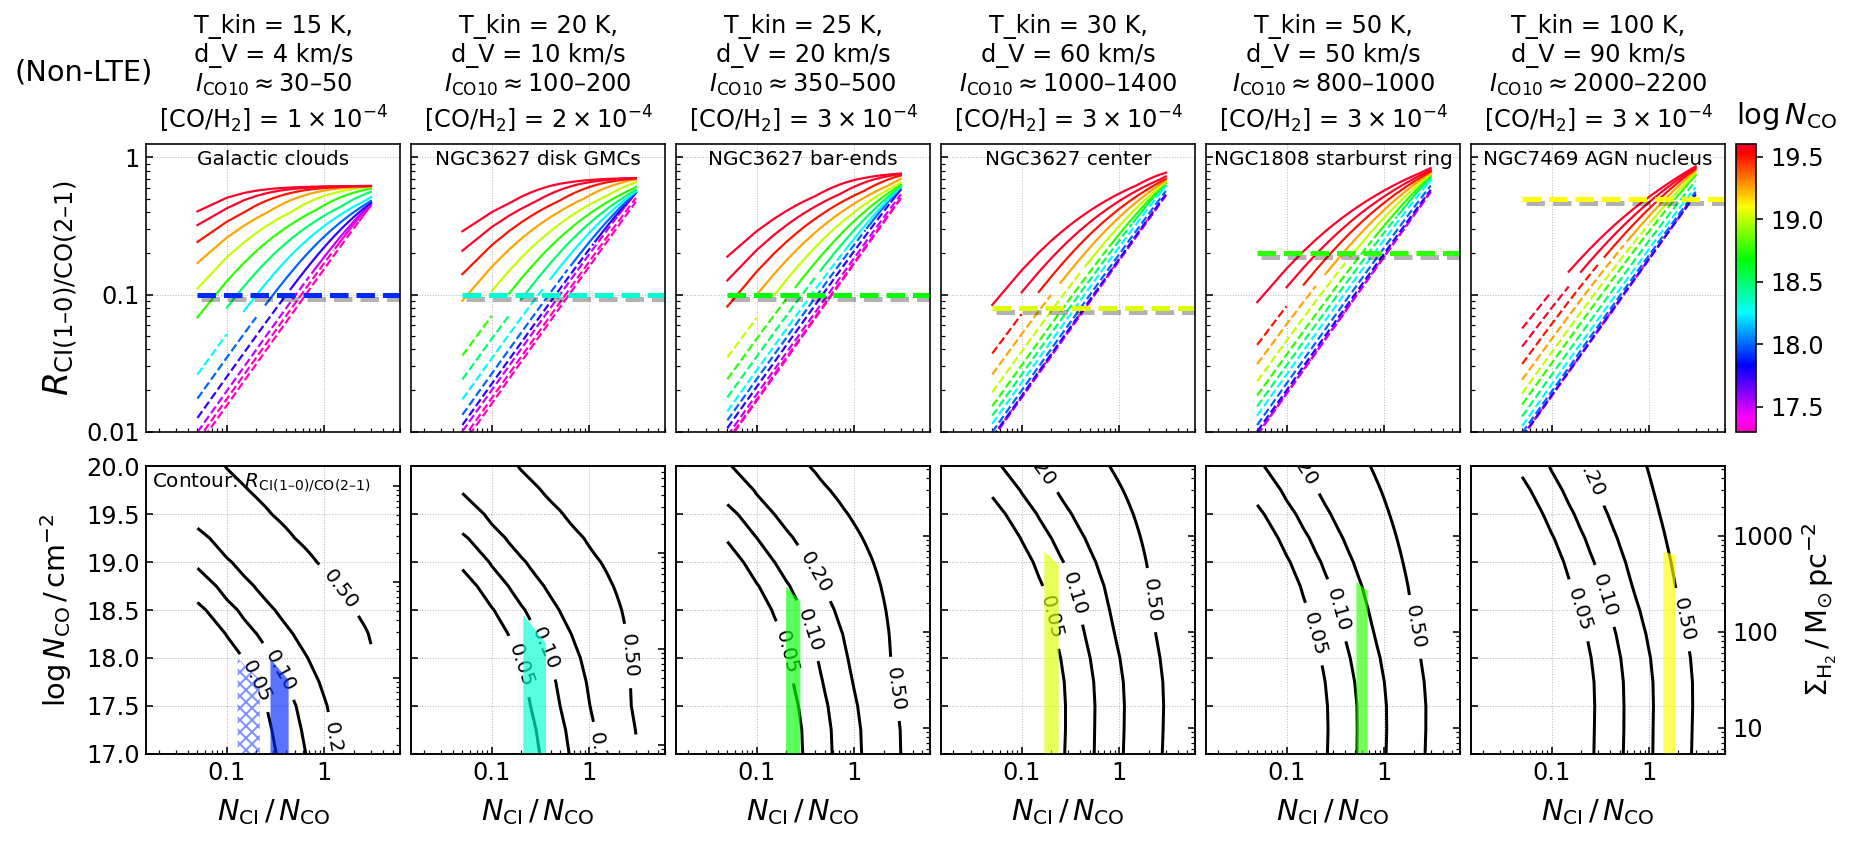

In [131]:

fig = make_a_figure(
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e2_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e2, 
        LTE = False, 
    )


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.03185920312477783, 0.5926877491867437)
highlight_X_CICO_range (0.099, 0.178)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.08333340257559531, 0.6143112743147198)
highlight_

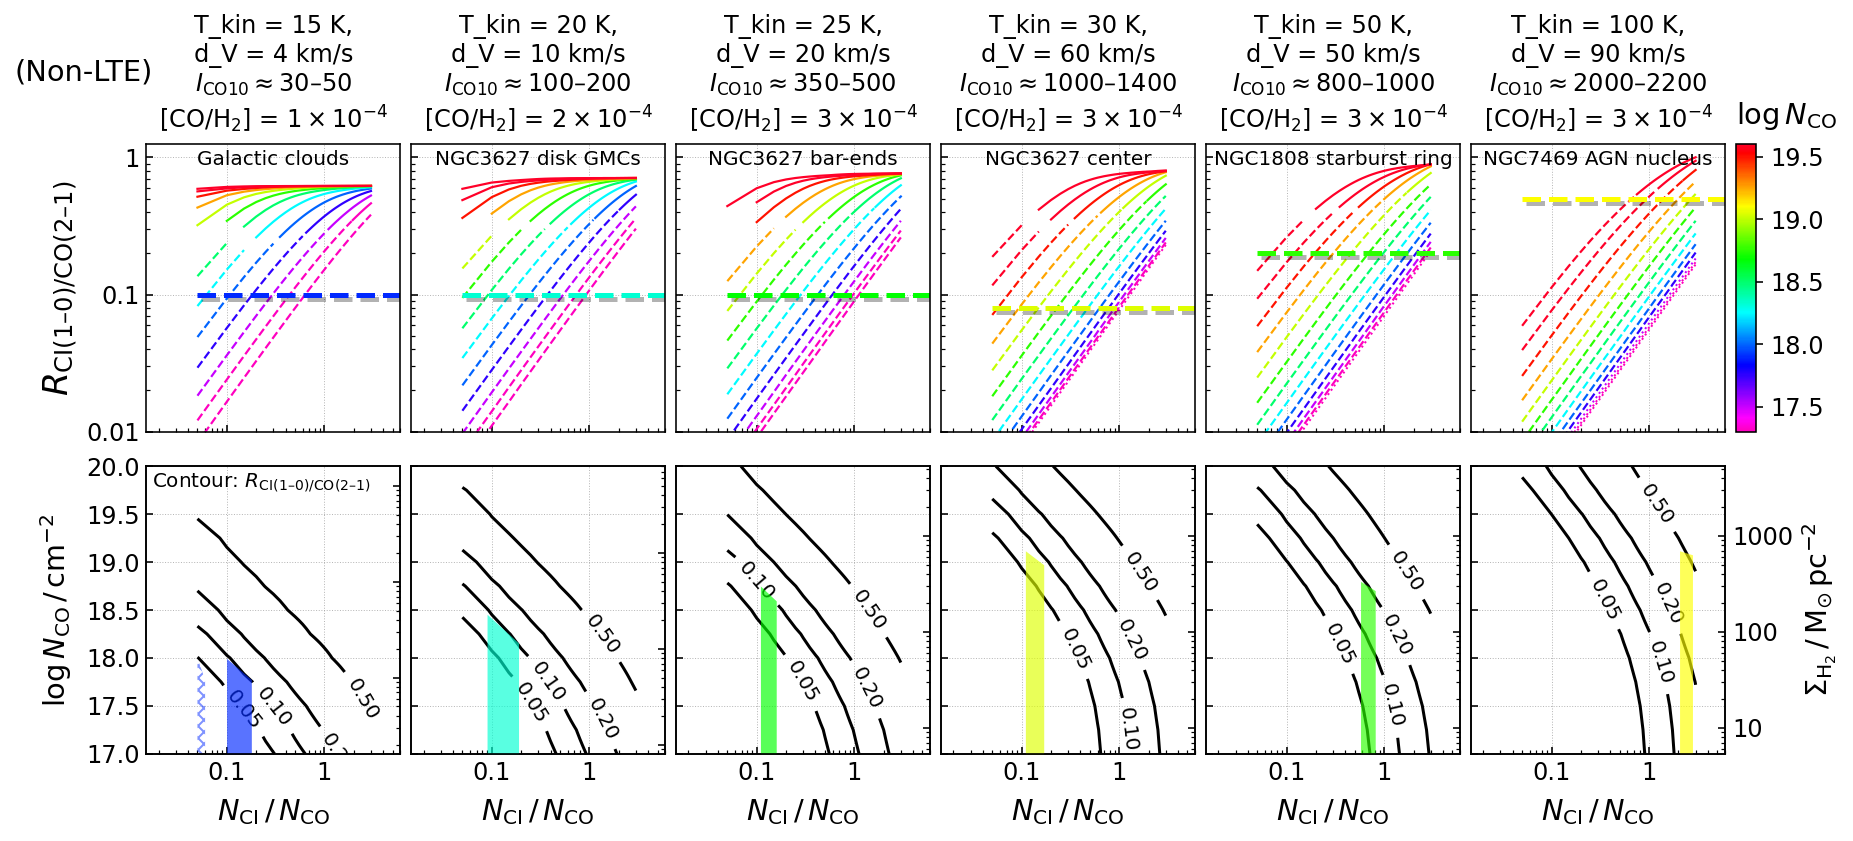

In [132]:

fig = make_a_figure(
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e3_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e3, 
        LTE = False, 
    )


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.04172213292488272, 0.6166919509101572)
highlight_X_CICO_range (0.08, 0.139)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.11286812420005964, 0.6189755609037599)
panel 2
CO_

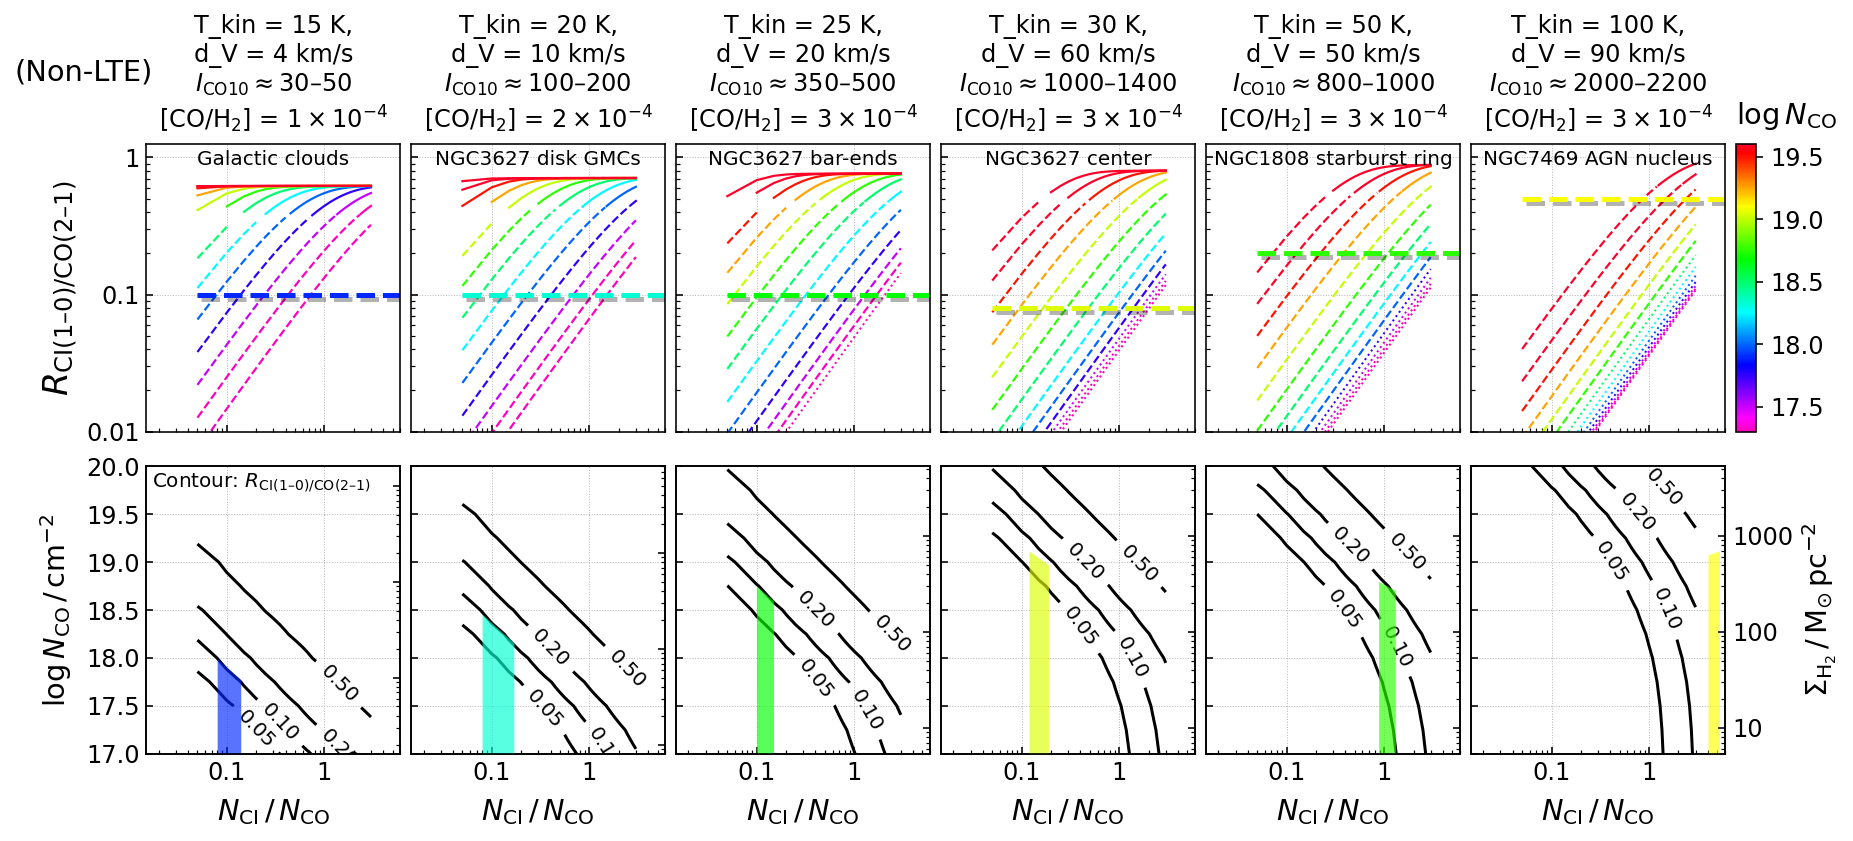

In [133]:

fig = make_a_figure(
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e4_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e4, 
        LTE = False, 
    )


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.0429244327262789, 0.618491899818893)
highlight_X_CICO_range (0.07, 0.129)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.11678692848653291, 0.6195985832349469)
panel 2
CO_ab

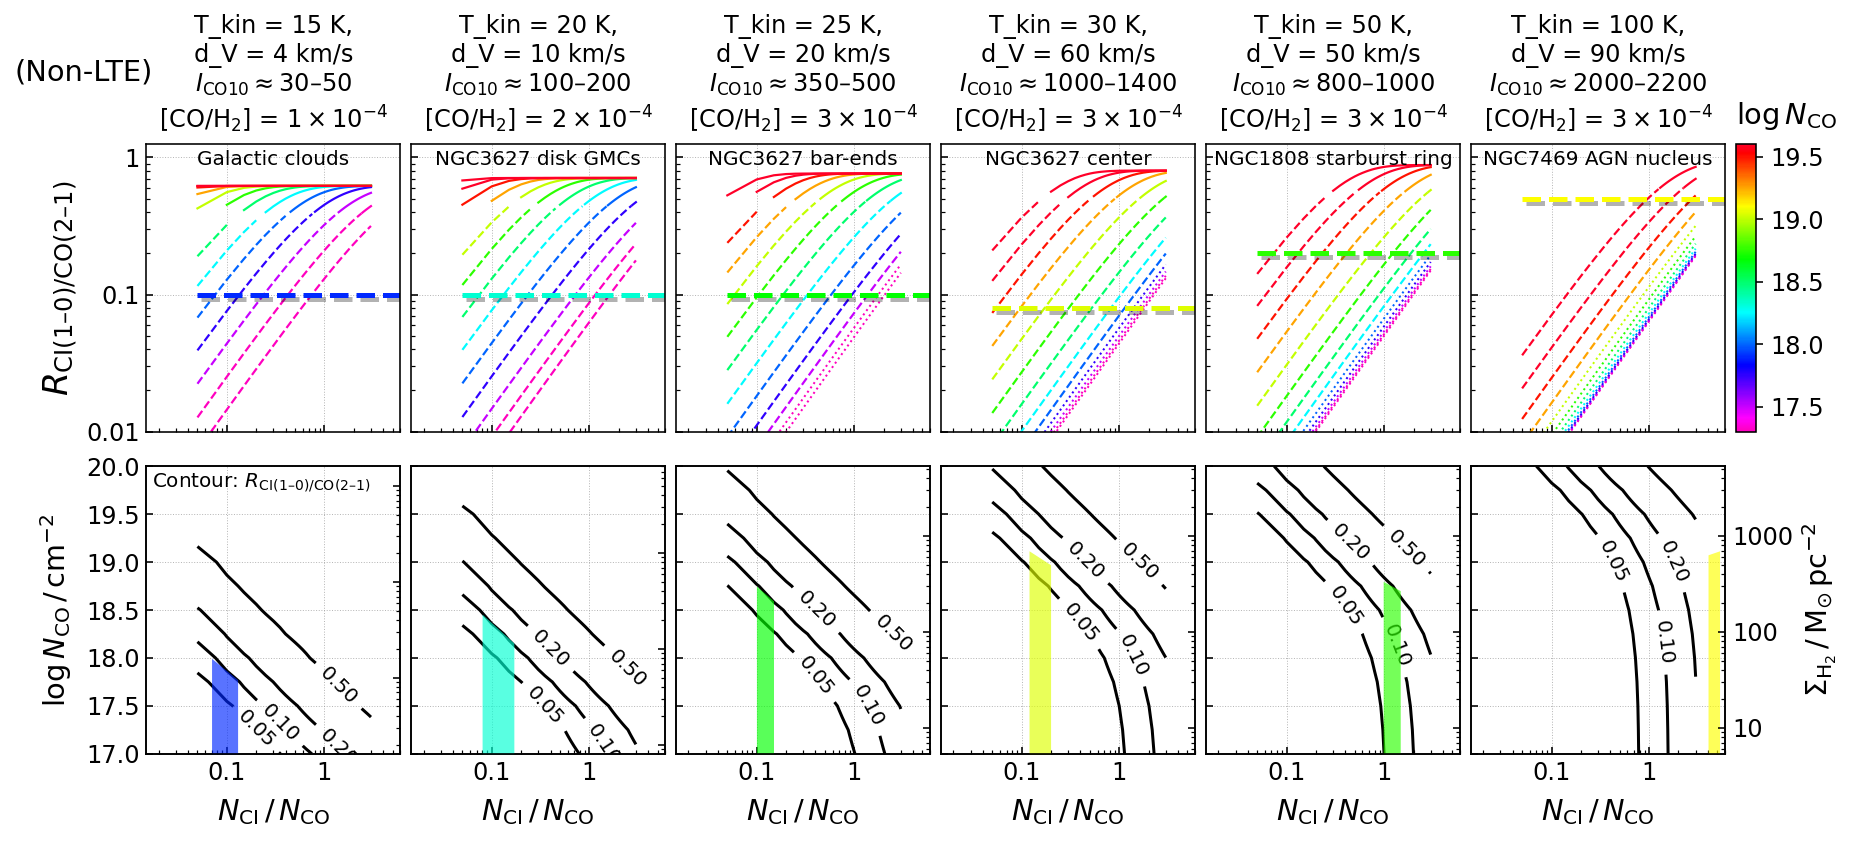

In [134]:

fig = make_a_figure(
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e5_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e5, 
        LTE = False, 
    )


panel 1
CO_abundance 0.0001
highlight_R_CI10CO21 0.1
highlight_Flux_Kkms_CO10_range (30.0, 50.0)
highlight_alphaCO 3.1696219080187253
highlight_Sigma_H2_range (95.08865724056176, 158.48109540093625) vs. right axis y range (16.0141791, 16014.1791)
highlight_N_CO_range [5.93777905e+17 9.89629842e+17]
highlight_N_CO_range in log10 [17.77362403 17.99547278]
highlight_N_CO_mean 7.917038739797097e+17 vs. left axis y range [1.e+17 1.e+20]
highlight_line_color (0.0, 0.15664961636828614, 1.0, 1.0)
highlight_R_CI10CO21_min_max_in_Sigma_H2_range (0.04305318627447435, 0.6186745087091077)
highlight_X_CICO_range (0.07, 0.129)
CO_abundance2 0.0003
highlight_alphaCO2 2.3868041488588734
highlight_Sigma_H2_range2 (71.6041244657662, 119.34020744294367)
highlight_N_CO_range2 [1.34138860e+18 2.23564767e+18]
highlight_N_CO_range2 in log10 [18.12755461 18.34940336]
highlight_N_CO_mean2 1.7885181380484547e+18
highlight_R_CI10CO21_min_max_in_Sigma_H2_range2 (0.1171650228492201, 0.619688385269122)
panel 2
CO_ab

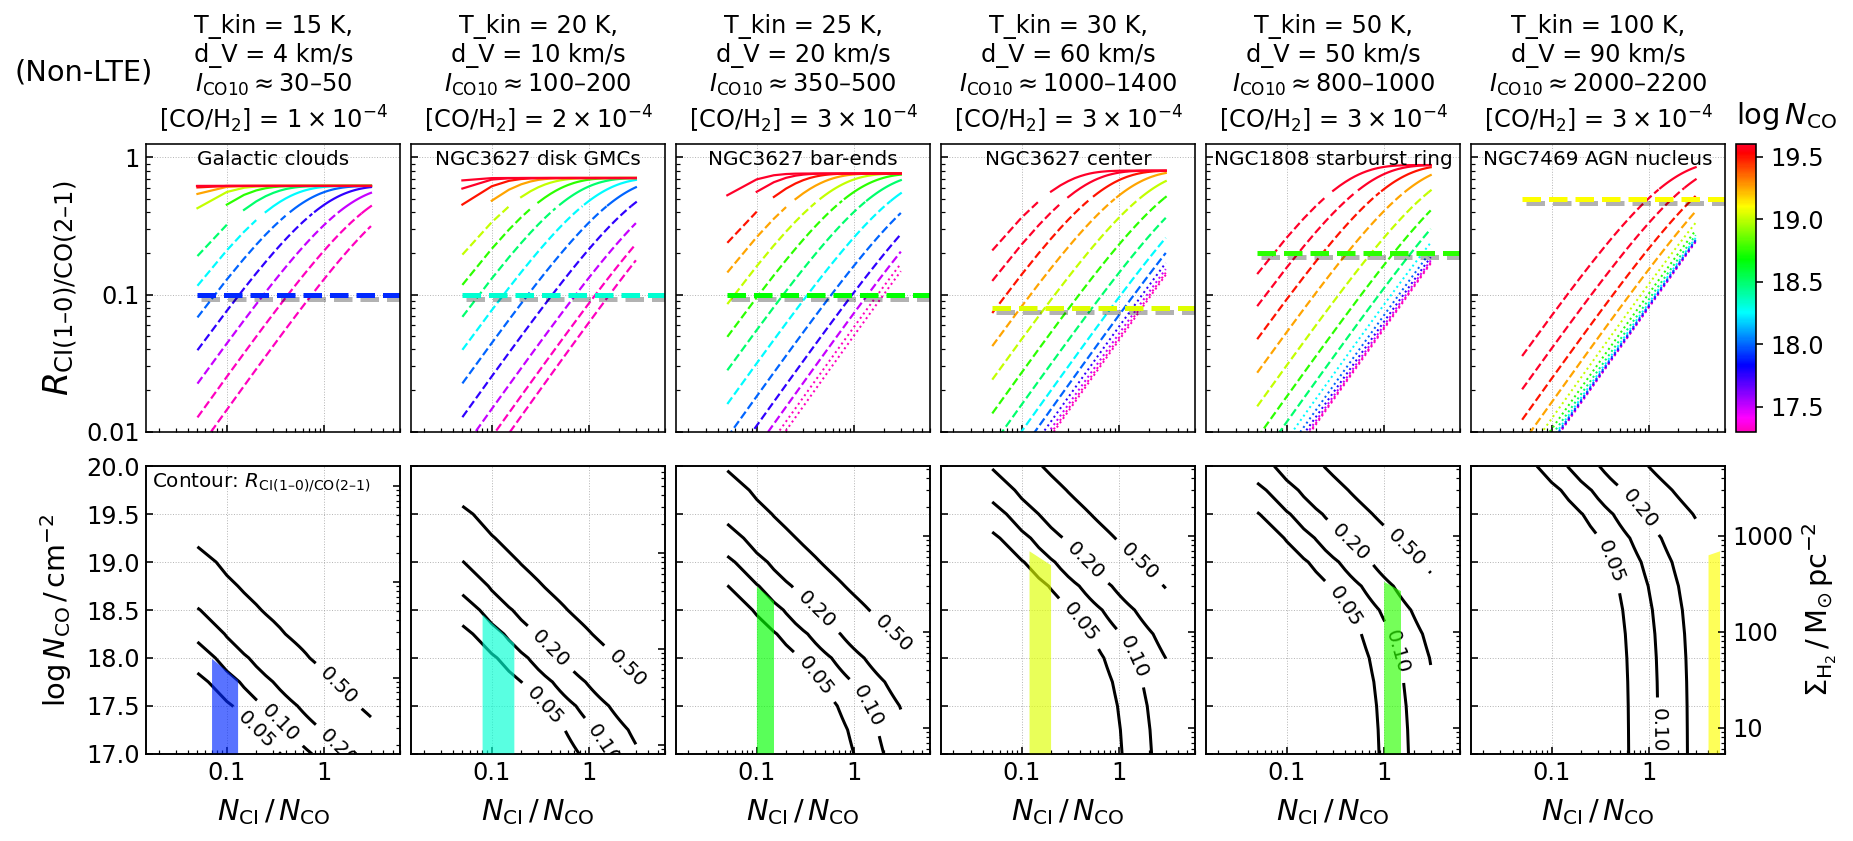

In [135]:

fig = make_a_figure(
        out_figure_file = out_fig_name + '_NonLTE_nH2_1e6_varying_N_CO_T_kin.pdf', 
        n_H2 = 1e6, 
        LTE = False, 
    )
